<a href="https://colab.research.google.com/github/weihanchen/google-colab-python-learn/blob/main/jupyter-examples/kd_strategy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 安裝必要套件
- [x] [yfinance](https://pypi.org/project/yfinance/): 獲取Yahoo Finance API的小幫手
- [x] [backtesting](https://kernc.github.io/backtesting.py/): 回測工具
- [x] [ta-lib](https://github.com/TA-Lib/ta-lib-python): 技術指標工具

P.S 此安裝步驟會運行一段時間， 主要是因為Ta-Lib的安裝方式比較特殊，需要重新Compile，約耗時3分鐘，可以喝個咖啡再回來看結果 😋

In [ ]:
# 安裝必要套件
!pip install yfinance backtesting

# 安裝Ta-Lib
!wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
!tar -xzvf ta-lib-0.4.0-src.tar.gz
%cd ta-lib
!./configure --prefix=/usr
!make
!make install
!pip install Ta-Lib

# 下載個股資訊
## 參數
- 股票代號。
- 開始時間。
- 結束時間。

In [ ]:
import yfinance as yf
import pandas as pd
from pandas_datareader import data
from datetime import datetime

################################# 請視需求帶入參數 ######################################
# 股票代號
stock_code = '0050.TW'

# 開始時間
start_date = datetime(2014, 7, 25)

# 結束時間
end_date = datetime(2022, 7, 25) 
###########################################################################################

# 獲取股票資料
yf.pdr_override() 

# 從yahoo資料源獲取台股代號的datafram
df = data.get_data_yahoo(stock_code, start_date, end_date) 

df.tail(10)

# 制定交易策略並進行回測
- 此步驟可以來來回回進行調優。


## 回測結果說明
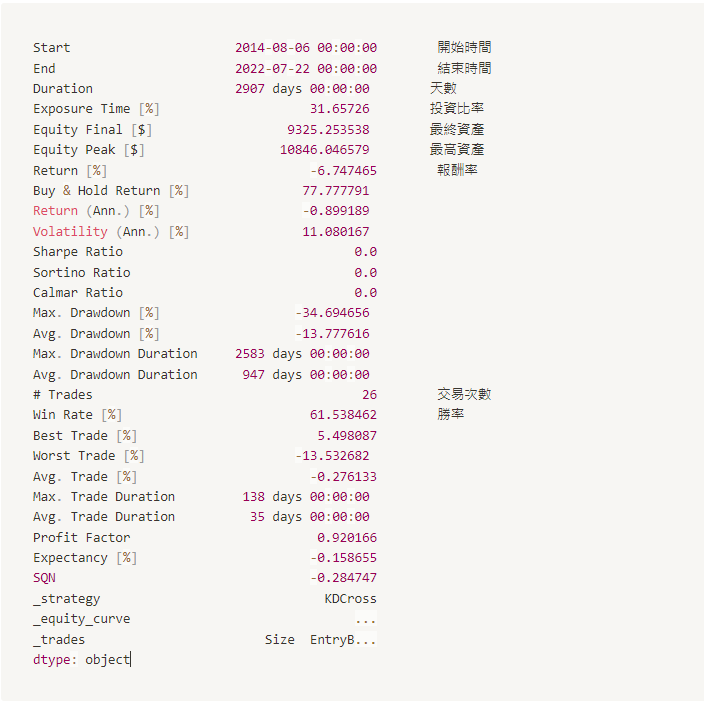

## 結語
由以下的結果我們可以看到兩個重要的欄位：
- Return \[%\](報酬率): -6.747465%。
- Win Rate \[%\](勝率): 61.538462%。

雖然勝率超過一半，但最終的報酬率仍是負的， 因此單純的KD指標可能不是最聰明的策略，我們可以根據上面的樣本進行KD策略的改良，例如： 加上大跌N%時才買進，來提高報酬率...等。

In [51]:
from backtesting import Backtest, Strategy 

from backtesting.lib import crossover
from backtesting.test import SMA

from talib import abstract

import pandas as pd


# bypass data in Strategy
def I_bypass(data): 
    return data
# 制定KD交易策略, K < 20買, 
class KDCross(Strategy): 
    lower_bound = 20  
    upper_bound = 80  

    def init(self):
        self.k = self.I(I_bypass, self.data.slowk) 
        self.d = self.I(I_bypass, self.data.slowd)

    def next(self):
        if crossover(self.k, self.d) and self.k<self.lower_bound and self.d<self.lower_bound and not self.position: #long position
            self.buy() 
        elif crossover(self.d, self.k) and self.k>self.upper_bound and self.d>self.upper_bound: 
            if self.position and self.position.is_long:
                self.position.close()

# CSV檔案中若有缺漏，會使用內插法自動補值
df = df.interpolate() 

# 將索引欄資料轉換成pandas的時間格式，backtesting才有辦法排序
df.index = pd.to_datetime(df.index) 

# 使用talib計算KD值
df_tmp = df
# rename for talib
df_tmp.rename(columns = {'High':'high', 'Low':'low','Adj Close':'close','Close':'non_adj close'}, inplace = True) 
kd = abstract.STOCH(df_tmp)
kd.index=df_tmp.index
# merge two data frame
fnl_df = df_tmp.join(kd).dropna() 
# rename column name for backtest
fnl_df.rename(columns = {'high':'High', 'low':'Low','close':'Close'}, inplace = True) 

# 資料來源, 交易策略, 現金, 手續費(%)
test = Backtest(fnl_df, KDCross, cash=10000, commission=.004)


# 執行回測程式並存到result中
result = test.run()

print(result)

test.plot()




Start                     2014-08-06 00:00:00
End                       2022-07-22 00:00:00
Duration                   2907 days 00:00:00
Exposure Time [%]                    31.65726
Equity Final [$]                  9325.253538
Equity Peak [$]                  10846.046579
Return [%]                          -6.747465
Buy & Hold Return [%]               77.777791
Return (Ann.) [%]                   -0.899189
Volatility (Ann.) [%]               11.080167
Sharpe Ratio                              0.0
Sortino Ratio                             0.0
Calmar Ratio                              0.0
Max. Drawdown [%]                  -34.694656
Avg. Drawdown [%]                  -13.777616
Max. Drawdown Duration     2583 days 00:00:00
Avg. Drawdown Duration      947 days 00:00:00
# Trades                                   26
Win Rate [%]                        61.538462
Best Trade [%]                       5.498087
Worst Trade [%]                    -13.532682
Avg. Trade [%]                    

Row(id='7021', ...)